In [1]:
# Get timings for each cell
%load_ext autotime

In [2]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip, sigma_clipped_stats
from ccdproc import ImageFileCollection

from tqdm import tqdm  # Progress bars

from piaa.utils import helpers
from pong.utils import storage
from piaa.utils import make_masks, pixel_hist

from matplotlib import pyplot as plt

/home/wtylergee/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/wtylergee/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


time: 2.34 s


### Get the calibration images

Download the files from google storage buckets. 

In [3]:
# Get our calibration images for the unit
calibration_images = storage.get_observation_blobs('PAN001/calibration/')

# Flats are included above but a more recent set was also taken
flat_images = storage.get_observation_blobs('PAN001/flats/')

time: 450 ms


In [4]:
# Save FITS files to this location
local_save_dir = '/var/panoptes/images/flats'
os.makedirs(local_save_dir, exist_ok=True)

time: 1.36 ms


In [5]:
# !!!WARNING - Download from the google storage buckets - lots of data - WARNING!!!
file_list = list()
for fn in tqdm(flat_images + calibration_images):
    local_fn = storage.download_fits_file(fn, save_dir=local_save_dir, unpack=False)
    file_list.append(local_fn)

100%|██████████| 316/316 [00:00<00:00, 28349.59it/s]

time: 17 ms


In [6]:
# Get the local path names
bias_list = [fn for fn in file_list if 'bias' in fn]
dark_list = [fn for fn in file_list if 'dark' in fn]
flat_list = [fn for fn in file_list if 'flat' in fn]

time: 1.81 ms


In [8]:
images = ImageFileCollection(location='/var/panoptes/images/flats/', glob_include='*dark*')

time: 333 ms


In [9]:
image_stats = list()

for i, hdu in tqdm(enumerate(images.hdus())):
    pixel_fit = pixel_hist(hdu, save_plot=True)
    
    fn = hdu.header['FILENAME']
    exptime = hdu.header['EXPTIME']
    dateobs = hdu.header['DATE-OBS']
    
    cam_id = 0
    if 'dark1' in fn:
        cam_id = 1
    
    for color, f in zip('rgb', pixel_fit):
        image_stats.append((dateobs, fn, color, exptime, f.mean.value, f.stddev.value, cam_id))

47it [02:01,  2.57s/it]

time: 2min 1s


In [10]:
df0 = pd.DataFrame(image_stats, columns=['dateobs', 'filename', 'color', 'exptime', 'mu', 'sigma', 'camid']).set_index(['dateobs'])

time: 8.05 ms


In [11]:
df1 = df0.groupby(by=['camid', 'exptime', 'color']).mean()

time: 22.8 ms


In [12]:
df1

mu      sigma
camid exptime color                        
0     0.9     b      2047.804366   7.837396
              g      2047.985046   7.881705
              r      2048.362205   7.769205
      30.0    b      2048.491243   7.083790
              g      2049.615396   7.271294
              r      2051.352915   7.653574
      60.1    b      2049.215642   7.302410
              g      2051.392155   7.910906
              r      2054.641518   9.511422
      90.2    b      2050.237382   7.597278
              g      2053.264719   8.718895
              r      2057.766820  12.005796
      120.3   b      2051.443901   7.977261
              g      2054.750184   9.855592
              r      2060.861262  15.012539
1     0.9     b      2048.010414   6.979166
              g      2047.977577   7.016251
              r      2048.047364   6.987407
      29.9    b      2049.484803   7.861202
              g      2051.635264   8.015629
              r      2056.022184   8.560960
      90.0    b      2052.914675   8.147301
              g      2058.006799   8.814502
              r      2069.942320  13.047614
      120.0   b      2054.835988   8.254202
              g      2061.642491   9.277171
              r      2077.888804  16.595238

time: 37.2 ms


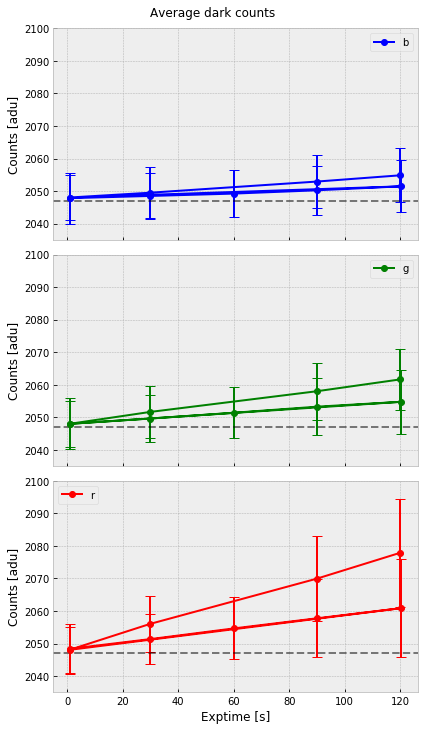

time: 832 ms


In [13]:
fig, ax = plt.subplots(3, 1, figsize=(6,10), sharex=True)
i = 0
for color, grp in df1.groupby(level=2):
    grp.reset_index().plot(
        x='exptime', 
        y='mu', 
        yerr='sigma', 
        marker='o', 
        label='{}'.format(color), 
        color=color, 
        ax=ax[i], 
        capsize=5,
    )
    
    ax[i].axhline(2047, color='k', ls='--', alpha=.5, label='bias')

    if i == 2:
        ax[i].set_xlabel('Exptime [s]')
    
    ax[i].set_ylabel('Counts [adu]')
    ax[i].set_ylim([2035, 2100])
    
    i += 1
    
fig.suptitle('Average dark counts', y=1.01)
fig.tight_layout()

### Calculate Gain 

Following the procedure here:

https://www.photometrics.com/resources/learningzone/gain.php

#### 1) Collect bias image

In [14]:
bias_data = np.array([fits.getdata(fn) - 2047 for fn in bias_list])

time: 2.27 s


In [15]:
bias_data.shape

(5, 3476, 5208)

time: 3.37 ms


#### 2) Collect two flats

In [19]:
# Get a list of the flat fields
flat_list = ImageFileCollection(location='/var/panoptes/images/flats/', glob_include='*_flat_*')

time: 262 ms


In [29]:
# Collect the data for good flats
flat_data = np.array([h - 2047 for h in flat_list.data()])

time: 3.75 s


Text(0,0.5,'mean counts (all channels) [adu]')

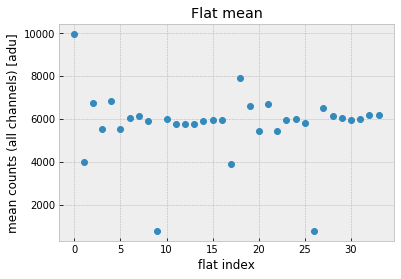

time: 814 ms


In [30]:
plt.plot(flat_data.reshape(flat_data.shape[0], -1).mean(axis=1), ls='', marker='o')
plt.title('Flat mean')
plt.xlabel('flat index')
plt.ylabel('mean counts (all channels) [adu]')

#### 3) Make a flat diff

In [31]:
# Select index number from ones that look stable above
id0 = -3
id1 = -1

flat_diff = sigma_clip(flat_data[id0].astype(np.float) - flat_data[id1].astype(np.float))

time: 25.5 s


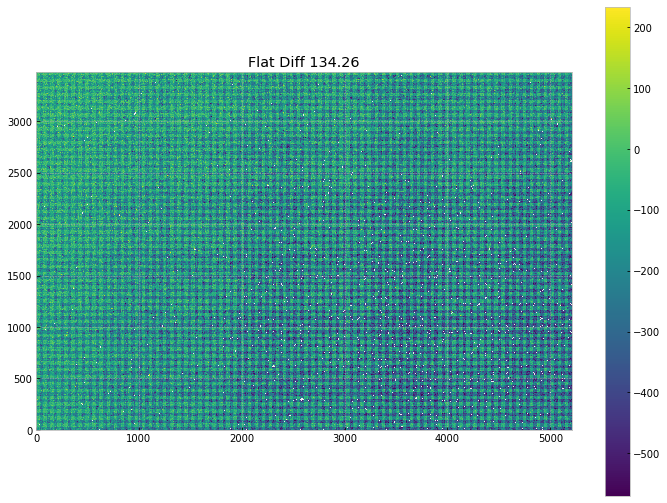

time: 3.39 s


In [32]:
plt.figure(figsize=(12,9))
plt.imshow(flat_diff, origin='lower')
plt.title("Flat Diff {:.02f}".format(flat_diff.std()))
plt.colorbar()

#### 4) Calculate std of center

In [33]:
num_images, img_h, img_w = flat_data.shape

time: 1.2 ms


In [34]:
center = int(img_h / 2), int(img_w / 2)

time: 1.49 ms


In [35]:
center_size = 100

time: 1.36 ms


In [36]:
flat_diff_center = Cutout2D(flat_diff, center, center_size).data

time: 2.03 ms


In [37]:
# Calculate RGB pattern for center
r_mask, g_mask, b_mask = helpers.get_rgb_masks(flat_diff_center, force_new=True)

time: 23.6 ms


In [38]:
r_flat_std = np.ma.array(flat_diff_center, mask=~r_mask).std()
g_flat_std = np.ma.array(flat_diff_center, mask=~g_mask).std()
b_flat_std = np.ma.array(flat_diff_center, mask=~b_mask).std()

time: 15.3 ms


In [39]:
print("R flat std: ", r_flat_std)
print("G flat std: ", g_flat_std)
print("B flat std: ", b_flat_std)

R flat std:  42.736682081790114
G flat std:  81.7941359228154
B flat std:  92.47052908428559
time: 2.19 ms


#### 5) Calculate variance of center

In [40]:
r_variance = (r_flat_std**2) / 2
g_variance = (g_flat_std**2) / 2
b_variance = (b_flat_std**2) / 2

time: 1.38 ms


In [41]:
print("R variance: ", r_variance)
print("G variance: ", g_variance)
print("B variance: ", b_variance)

R variance:  913.2119976800001
G variance:  3345.14033568
B variance:  4275.399374563854
time: 1.59 ms


#### 6) Calculate bias-corrected flat

Text(0.5,1,'Bias corrected flat')

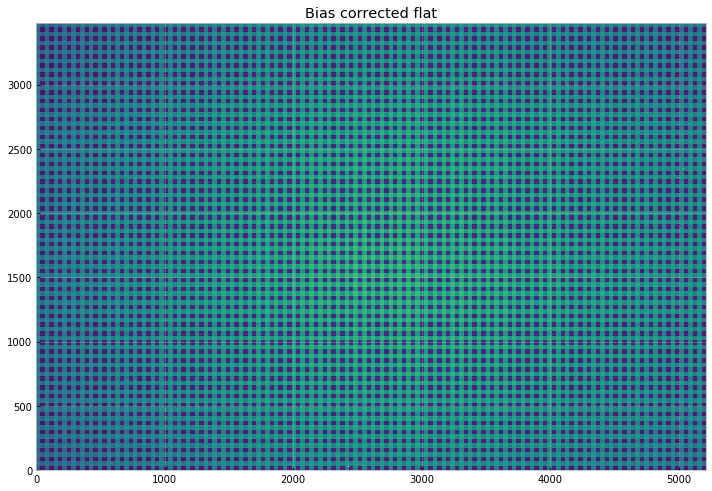

time: 17.3 s


In [42]:
bias_corrected = sigma_clip(flat_data[1] - bias_data[1])

plt.figure(figsize=(12,9))
plt.imshow(bias_corrected, origin='lower')
plt.title('Bias corrected flat')

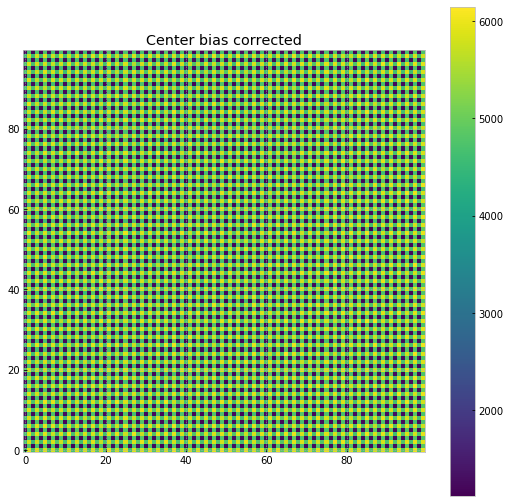

time: 420 ms


In [43]:
bias_corrected_center = Cutout2D(bias_corrected, center, 100)

plt.figure(figsize=(9,9))
plt.imshow(bias_corrected_center.data)
plt.title("Center bias corrected")
plt.colorbar()

#### 7) Calculate mean illumination for center of bias corrected

In [44]:
r_center = np.ma.array(bias_corrected_center.data, mask=~r_mask)
g_center = np.ma.array(bias_corrected_center.data, mask=~g_mask)
b_center = np.ma.array(bias_corrected_center.data, mask=~b_mask)

time: 2.94 ms


In [45]:
r_mean_illumination = r_center.mean()
g_mean_illumination = g_center.mean()
b_mean_illumination = b_center.mean()

time: 2.36 ms


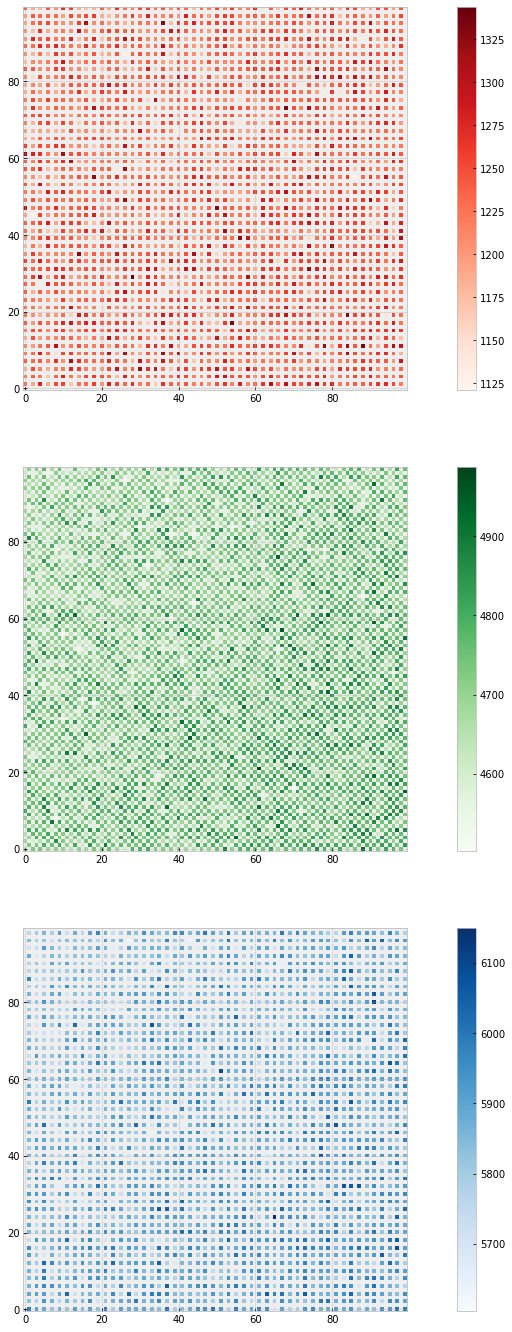

time: 1.29 s


In [46]:
fig = plt.figure(figsize=(18,24))

ax1 = plt.subplot(3, 1, 1)
im_r = ax1.imshow(r_center, cmap='Reds')
fig.colorbar(im_r, ax=ax1)

ax2 = plt.subplot(3, 1, 2)
im_g = ax2.imshow(g_center, cmap='Greens')
fig.colorbar(im_g, ax=ax2)

ax3 = plt.subplot(3, 1, 3)
im_b = ax3.imshow(b_center, cmap='Blues')
fig.colorbar(im_b, ax=ax3)

In [47]:
print("R mean illum: ", r_mean_illumination)
print("G mean illum: ", g_mean_illumination)
print("B mean illum: ", b_mean_illumination)

R mean illum:  1232.3916
G mean illum:  4733.003
B mean illum:  5867.3868
time: 1.98 ms


#### 8) Gain = mean / variance

In [48]:
r_gain = r_mean_illumination / r_variance
g_gain = g_mean_illumination / g_variance
b_gain = b_mean_illumination / b_variance

time: 1.27 ms


In [49]:
print("R gain: ", r_gain)
print("G gain: ", g_gain)
print("B gain: ", b_gain)

R gain:  1.349513150430426
G gain:  1.4148892198981167
B gain:  1.3723599331813416
time: 2.58 ms
